# Linear model

Nesse notebook, será desenvolvida uma análise preditiva com modelos lineares de regressão logística com regularização do tipo Lasso, Ridge e ElasticNet.

In [164]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
#from sklearn.pipeline import Pipeline

In [2]:
%matplotlib inline

sns.set(font_scale=0.9)

# seed padrão
seed = 101

## Importando dataset

In [198]:
datapath = Path('../data')
outpath = Path('../models')

with open(f'{datapath}/data.pickle', 'rb') as file:
    data = pickle.load(file)

In [4]:
data.head(2)

,status_check_acc,duration,cred_history,purpose,cred_amount,savings,employment_since,installment,other_deb,resid_since,...,other_installment,housing,n_creds,job,n_liable_people,tel,foreign,cred_score,gender,social_status
0,0 DM,6,critical,radio/television,1169.0,None,>= 7 years,4,None,4,...,none,own,2,skilled,1,1,1,0,M,single
1,<200 DM,48,all paid,radio/television,5951.0,<100 DM,< 4 years,2,None,2,...,none,own,1,skilled,1,0,1,1,F,divorced/separated


## Separando variáveis preditoras e dependente (X e y)

In [5]:
X = data.drop('cred_score', axis=1).copy()
y = data['cred_score'].copy()

## Padronizando variáveis numéricas contínuas

As variáveis numéricas, porém discretas, serão tratadas como categóricas. No entanto, não serão sujeitas ao processo de `OneHotEncoding`.

In [7]:
continuous_vars = [col for col in X.columns if X[col].dtype == 'float']
print(continuous_vars)

['cred_amount']


<AxesSubplot:xlabel='cred_amount', ylabel='Count'>

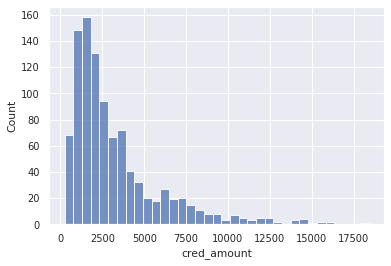

In [6]:
sns.histplot(X['cred_amount'])

**OBS:** como podemos inferir a partir do histograma acima, a variável cred_amount não segue uma distribuição normal. Assim, vamos apenas padronizá-la de forma que apenas a sua escala seja ajustada em torno de uma variância 1.

In [9]:
X['cred_amount'] = scale(X['cred_amount'])

<AxesSubplot:xlabel='cred_amount', ylabel='Count'>

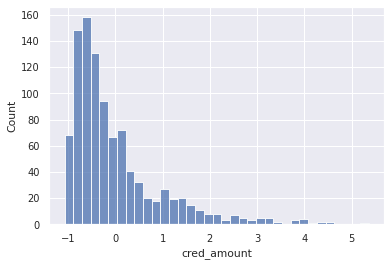

In [10]:
sns.histplot(X['cred_amount'])

## OneHotEncoding

Nesse passo, vamos converter todas as variáveis categóricas em dummies.

In [11]:
categorical_vars = [col for col in X.columns if X[col].dtype not in ['int', 'float']]
numerical_vars = [col for col in X.columns if col not in categorical_vars]

print('categorical_vars: ',categorical_vars)
print('\nnumerical_vars: ',numerical_vars)

categorical_vars:  ['status_check_acc', 'cred_history', 'purpose', 'savings', 'employment_since', 'other_deb', 'property', 'other_installment', 'housing', 'job', 'tel', 'foreign', 'gender', 'social_status']

numerical_vars:  ['duration', 'cred_amount', 'installment', 'resid_since', 'age', 'n_creds', 'n_liable_people']


In [12]:
# criando dummies
X_dummy = pd.get_dummies(X[categorical_vars], drop_first=True)

In [13]:
# agregando ao conjunto de features X
X = pd.concat([X[numerical_vars], X_dummy], axis=1)

## Train Test Split

Nesse passo, vamos separar um conjunto de treino e um de teste (_holdout_) para posterior avaliação fora da amostra. Como a amostra contém apenas 1000 registros, reservaremos 20% para compor o conjunto de teste. Será selecionado o modelo com o melhor *cross_validation_score* dentro da amostra de treino.

**OBS:** é importante que seja definido o parâmetro `stratify` para que sejam mantidas as mesmas proporções de clientes com score bom e ruim observadas na amostra.

In [14]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, stratify=y, test_size=0.2, random_state=seed)

## Estimando Regressão Logística

Com esse modelo, esperamos ter uma primeira medida de performance para modelos lineares que será usada como benchmark para modelos de árvore.

-----

É importante, nesse passo, discutir qual métrica utilizar para avaliar o modelo, levando em consideração o desbalanceamento observado da amostra. 

Duas candidatas razoáveis são: `ROC AUC Score` e `f1`.

Analisando o problema de negócio sob a ótica do Banco (agente que vai conceder o empréstimo), queremos evitar duas situações: 

1. Emprestar erroneamente recursos para um cliente classificado como de baixo risco, enquanto que, na verdade, o cliente é de alto risco (**Falso Positivo**).
2. Não conceder crédito a um cliente de baixo risco classificado erroneamente como de alto risco. (**Falso Negativo**)

**Raciocínio:** Em outras palavras, estamos interessados em reduzir, ao máximo, o número de Falsos Positivos e Falsos Negativos.


-----
<font color='red'>**OBS:**</font>
No entanto, devemos atentar para o fato de que, em um dataset desbalanceado, o número de verdadeiros positivos tende a ser superestimado. Logo, a métrica `roc_auc_score` pode não ser a mais adequada para este problema devido à possibilidade de esta ser superestimada. 

Sendo assim, vamos prosseguir a análise utilizando a métrica `f1` para priorizar `precision` e `recall`.

$$ 
F_{\beta} = (1+\beta^2)\frac{precicion*recall}{\beta^2 * precision + recall}
$$

$$
precision = \frac{tp}{tp + fp},~~recall=\frac{tn}{tn+fp}
$$

In [142]:
# grid de parâmetros
param_grid={"C":np.logspace(-4,4,9), "penalty":["none", "elasticnet", "l2"], # l1 lasso l2 ridge 
           "class_weight":[None,"balanced"], 
           "solver":['lbfgs', 'liblinear']} # default vs solver para datasets pequenos

In [177]:
%%capture --no-display
# capturando warnings (para alguns parãmetros do grid search, não houve convergência)

start_train_time = datetime.now()

logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid, cv=3, scoring='f1')  # 3 fold devido ao número de registros
logreg_cv.fit(X_train, y_train)

end_train_time = datetime.now()

train_time = end_train_time - start_train_time

In [189]:
print('Logistic Regression best params:', logreg_cv.best_params_)
print('Logistic Regression best F1 score:', logreg_cv.best_score_)

Logistic Regression best params: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression best F1 score: 0.5910029030596406


### Avaliando o modelo de Regressão Logística

vamos começar avaliando o modelo no conjunto holdout

In [190]:
start_eval_time = datetime.now()

y_pred = logreg_cv.predict(X_holdout)  # calculando previsões com threshold de treino
y_pred_proba = logreg_cv.predict_proba(X_holdout)[:,1]  # calculando probabilidades

end_eval_time = datetime.now()

eval_time = end_eval_time - start_eval_time

#### Matriz de Confusão e Relatório de Classificação

Na matriz de confusão, temos as seguintes informações: 

$
\left[
  \begin{matrix}
   tp & fp  \\
   fn & tn  
  \end{matrix} 
\right]
  = 
\left[
  \begin{matrix}
   true~positives & false~positives  \\
   false~negatives & true~negatives  
  \end{matrix}
\right]
$

In [191]:
print(confusion_matrix(y_holdout, y_pred))

[[101  39]
 [ 18  42]]


In [192]:
print(classification_report(y_holdout, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.72      0.78       140
           1       0.52      0.70      0.60        60

    accuracy                           0.71       200
   macro avg       0.68      0.71      0.69       200
weighted avg       0.75      0.71      0.72       200



#### Curva ROC

Na presente aplicação, a curva ROC se faz relevante pois tende a ser insensível a conjuntos de dados com proporções de classes desbalanceadas. 

Isto posto, a área abaixo da curva ROC é uma importante métrica para avaliar o desempenho do modelo.

----

Vamos começar calculando as taxas de verdadeiros positivos e falsos positivos.

In [193]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_holdout, y_pred_proba)

Text(0, 0.5, 'Taxa de Verdadeiros Positivos')

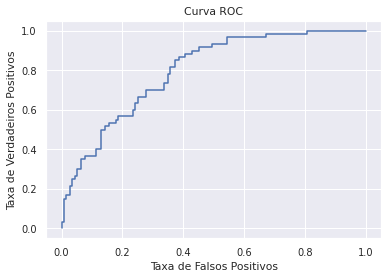

In [194]:
plt.plot(false_pos_rate, true_pos_rate)

# labels
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')

In [202]:
auc_score = roc_auc_score(y_holdout, y_pred)
print('ROC AUC score:', auc_score)

ROC AUC score: 0.7107142857142857


## Sintetizando métricas e exportando modelo

Avaliando e exportando métricas no conjunto holdout

### Mean Squared Error

Para comparação com outros modelos

In [196]:
mse = MSE(y_holdout, y_pred)
rmse = mse**(1/2)

### Exportando métricas

In [219]:
precision = precision_score(y_holdout, y_pred)
recall = recall_score(y_holdout, y_pred)
accuracy = accuracy_score(y_holdout, y_pred)
balanced_accuracy = balanced_accuracy_score(y_holdout, y_pred)
f1 = f1_score(y_holdout, y_pred)

# confusion_matrix
matrix = confusion_matrix(y_holdout, y_pred)

In [220]:
metrics_dict = {
    'precision'        : precision,
    'recall'           : recall,
    'accuracy'         : accuracy,
    'balanced_accuracy': balanced_accuracy,
    'f1'               : f1,
    'roc_auc_score'    : auc_score,
    'confusion_matrix' : matrix,
    'train_time'       : train_time,
    'eval_time'        : eval_time
}

### Exportando métricas

In [221]:
with open(f'{outpath}/logistic_regression_holdout_metrics.pickle', 'wb') as file:
    pickle.dump(metrics_dict, file)

### Exportando modelo

In [222]:
best_model = logreg_cv.best_estimator_

In [223]:
with open(f'{outpath}/logistic_regression.pickle', 'wb') as file:
    pickle.dump(best_model, file)

**Fim!**